# Project Part 1

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/cs39aa_project/blob/main/project_part1.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/cs39aa_project/blob/main/project_part1.ipynb)

This notebook is intended to serve as a template to complete Part 1 of the projects. Feel free to modify this notebook as needed, but be sure to have the two main parts, a) a introductory proposal section describing what it is your doing to do and where the dataset originates, and b) an exploratory analysis section that has the histograms, charts, tables, etc. that are the output from your exploratory analysis. 

__Note you will want to remove the text above, and in the markdown cells below, and replace it with your own text describing the dataset, task, exploratory steps, etc.__

## Introduction/Background

_In this section you will describe (in English) the dataset you are using as well as the NLP problem it deals with. For example, if you are planning to use the Twitter Natural Disaster dataset, then you will describe what the data and where it came as if you were explaining it to someone who does not know anything about the data. You will then describe how this is a __text classification__ problem, and that the labels are binary (e.g. a tweet either refers to a genuine/real natural disaster, or it does not)._ 

_Overall, this should be about a paragraph of text that could be read by someone outside of our class, and they could still understand what it is your project is doing._ 

_Note that you should __not__ simply write one sentence stating, "This project is base on the Kaggle competition: Predicting Natural Disasters with Twitter._"

_If you are still looking for datasets to use, consider the following resources to explore text datasets._

* https://huggingface.co/datasets
* https://www.kaggle.com/datasets
* https://pytorch.org/text/stable/datasets.html
* https://github.com/niderhoff/nlp-datasets 
* https://medium.com/@ODSC/20-open-datasets-for-natural-language-processing-538fbfaf8e38 
* https://imerit.net/blog/25-best-nlp-datasets-for-machine-learning-all-pbm/ 
* https://index.quantumstat.com/#dataset


## Exploratory Data Analysis

_You will now load the dataset and carry out some exploratory data analysis steps to better understand what text data looks like. See the examples from class on 10/. The following links provide some good resources of exploratory analyses of text data with Python._


* https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
* https://regenerativetoday.com/exploratory-data-analysis-of-text-data-including-visualization-and-sentiment-analysis/
* https://medium.com/swlh/text-summarization-guide-exploratory-data-analysis-on-text-data-4e22ce2dd6ad  
* https://www.kdnuggets.com/2019/05/complete-exploratory-data-analysis-visualization-text-data.html  


In [1]:
!pip install pyLDAvis
!pip install textstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import sklearn
import gensim
import pyLDAvis
import wordcloud
import textblob
import spacy
import textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=406c7526175b6b3d80171fc43bf8b62c82c2539a5ac413491b62619e5e3df7b4
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=1051d9ce5a6be12ca734591a5d687880c5bfb3d6cb86ee222b798b71be9f1e7d
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built pyLDAvis sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv('rtom.csv')

tomatoes = data.dropna()
tomatoes.reset_index(inplace=True)
print(tomatoes.shape)
print(tomatoes.head())

selections1 = ['Review_Type', 'review_content']
selections2 = ['Top_Critic', 'review_content']
X = tomatoes[selections1].copy()
X2 = tomatoes[selections2].copy()
y = tomatoes.pop('Review_Type')
y2 = tomatoes.pop('Top_Critic')
print(X.shape)

Saving rtom.csv to rtom.csv
(7089, 11)
   index rotten_tomatoes_link       critic_name  top_critic  Top_Critic  \
0      3            m/0814255      Ben McEachen       False           0   
1      6            m/0814255      Nick Schager       False           1   
2      7            m/0814255  Bill Goodykoontz        True           0   
3      8            m/0814255    Jordan Hoffman       False           1   
4      9            m/0814255      Jim Schembri        True           0   

            publisher_name review_type  Review_Type review_score review_date  \
0  Sunday Mail (Australia)       Fresh            1        3.5/5    2/9/2010   
1           Slant Magazine      Rotten            0        4-Jan   2/10/2010   
2         Arizona Republic       Fresh            1        3.5/5   2/10/2010   
3                      UGO       Fresh            1            B   2/10/2010   
4      The Age (Australia)       Fresh            1        5-Mar   2/10/2010   

                             

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, random_state=1)
pd.set_option("display.max_colwidth", 300)
print(X_train.shape)
print(y_train.shape)
print(X_train.head(10))  # Rotten=0, Fresh=1

(5671, 2)
(5671,)
      Review_Type  \
2707            0   
5397            1   
4137            0   
4821            1   
2836            1   
6414            1   
2900            1   
2093            0   
1412            1   
1190            1   

                                                                                                                                                                        review_content  
2707                                         Slickly made but utterly gratuitous, this wannabe-edgy thriller was an odd choice for Ventimiglia to make during his first Heroes hiatus.  
5397                                         Working with utterly predictable material, screenwriter Kevin Hench finds plenty of offbeat humor, and Carolla knows how to make it sing.  
4137                                                                                             Sirk or Billy Wilder could have done something with it. Sachs still has a ways to go.  
4821      

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

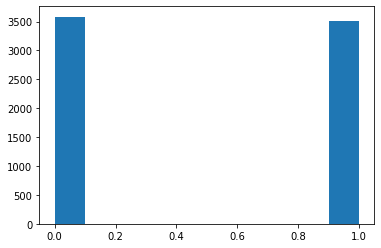

In [4]:
import matplotlib.pyplot as plt
plt.hist(y)
plt

In [5]:
import numpy as np
y_num = np.asarray(y)
unique, counts = np.unique(y_num, return_counts=True)
print(f"Count of 0 = Rotten and 1 = Fresh: {dict(zip(unique, counts))}") 

Count of 0 = Rotten and 1 = Fresh: {0: 3583, 1: 3506}


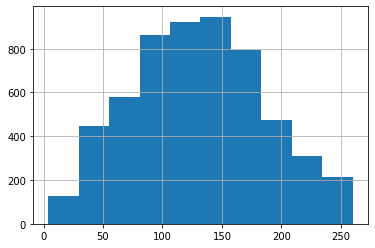

In [6]:
X_train['review_content'].str.len().hist()

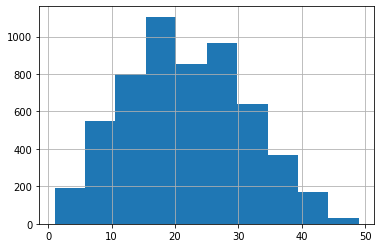

In [7]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
plot_word_number_histogram(X_train['review_content'])

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))
corpus=[]
new= X_train['review_content'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

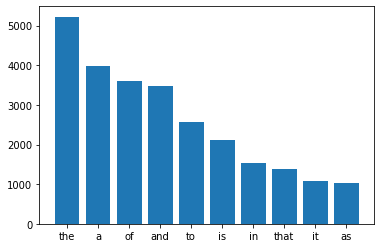

In [10]:
plot_top_stopwords_barchart(X_train['review_content'])

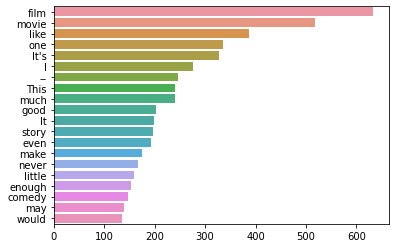

In [14]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    chars2remove = set(['.', '!', '/', '?', ',', '@', '#', '$', '%', '^', '&', '*', '_', '-', '~'])
    #X_train['tokens_raw'] = X_train['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:80]:
        if (word not in stop and word != 'The' and word != 'A' and word != chars2remove):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    chars2remove = set(['.', '!', '/', '?', ',', '@', '#', '$', '%', '^', '&', '*', '_', '-', '~'])
    #X_train['tokens_raw'] = X_train['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:80]:
        if (word not in stop and word != 'The' and word != 'A' and word != chars2remove):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

plot_top_non_stopwords_barchart(X_train['review_content'])

In [17]:
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))
corpus=[]
new= X_train['review_content'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

from nltk.tokenize import TreebankWordTokenizer

twt = TreebankWordTokenizer()
X['tokens_raw'] = X['review_content'].apply(lambda x: twt.tokenize(x.lower()))
chars2remove = set(
    ['.', '!', '/', '?', ',', '@', '#', '$', '%', '^', '&', '*', '_', '-', '~', 'The', 'A', '`', '+', "'", '"', '--',
     '[', ']',
     "'s", "n't"])
X['tokens_raw'] = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
pd.set_option("display.max_colwidth", 300)
X_tRaw = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
Xtclean = X_tRaw.apply(lambda x: ' '.join(x))
print(X_tRaw.head(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                 [whether, audiences, get, behind, lightning, thief, hard, predict., overall, entertaining, introduction, promising, new, world, consuming, shadow, potter, big, break, free]
1                                                                           [harry, potter, knockoffs, come, transparent, slapdash, wannabe-franchise, jumpstarter, directed, chris, columbus]
2                                                                      [percy, jackson, great, movie, good, one, trotting, kernels, greek, mythology, like, many, disney, channel, references]
3                                                                                                                                                                    [fun, brisk, imaginative]
4    [crammed, dragons, set-destroying, fights, things, exploding, columbus, squeezes, well-meaning, pause, breaks, friendship, absent, fathers, swiftly, moving, next, pyrotechnics, display]
5          [action-packed, fantasy, adventure

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
X_hot = tfidf_vect.fit_transform(Xtclean).toarray()
print(X_hot[:3, :5])
import torch

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [19]:
X_tense = torch.tensor(X_hot).float()
print(Xtclean.head())
print(X.shape)

0                  whether audiences get behind lightning thief hard predict. overall entertaining introduction promising new world consuming shadow potter big break free
1                                                                   harry potter knockoffs come transparent slapdash wannabe-franchise jumpstarter directed chris columbus
2                                                                  percy jackson great movie good one trotting kernels greek mythology like many disney channel references
3                                                                                                                                                    fun brisk imaginative
4    crammed dragons set-destroying fights things exploding columbus squeezes well-meaning pause breaks friendship absent fathers swiftly moving next pyrotechnics display
Name: tokens_raw, dtype: object
(7089, 3)


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_tense, y, train_size=0.80, random_state=1)
print(X_train.size())
print(y_train.shape)

torch.Size([5671, 15862])
(5671,)


In [21]:
class Classification:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def extraTree(self, n):
        from sklearn.ensemble import ExtraTreesClassifier
        import matplotlib.pyplot as plt
        model = ExtraTreesClassifier()
        model.fit(self.X, self.y)
        feat_importances = pd.Series(model.feature_importances_, index=self.X.columns)
        feat_importances.nlargest(n).plot(kind='barh')
        plt.show()
        feat = []
        feat.append(feat_importances.nlargest(n))
        return feat

    def normal(self, feature):
        import matplotlib.pyplot as plt
        plt.hist(self.X[feature], bins=20, edgecolor='black')
        plt.show()

    def reg(self):
        from sklearn.linear_model import LinearRegression
        import matplotlib.pyplot as plt
        linreg_model = LinearRegression()
        linreg_model.fit(self.X, self.y)
        import statsmodels.api as sm
        regModel = sm.OLS(self.y, self.X).fit()
        y_pred = linreg_model.predict(self.X)
        # and a residual plot
        plt.title('Residulas')
        plt.scatter(regModel.model.exog[:, 1], regModel.resid)
        plt.show()
        mse_linreg = ((y_pred ** 2).mean())
        print("MSE = ", mse_linreg)
        print("rMSE = ", np.sqrt(mse_linreg))
        return regModel.summary()  # finally return a Regression Summary


class DecisionTree(Classification):
    def __init__(self, X, y):
        super().__init__(X, y)

    def decision(self, n, feat):
        from sklearn.tree import DecisionTreeClassifier
        from sklearn import tree
        import matplotlib.pyplot as plt
        clf = tree.DecisionTreeClassifier(max_depth=n)  # set hyperparameter
        clf.fit(self.X, self.y)
        plt.figure(figsize=(12, 12))  # set plot size (denoted in inches)
        tree.plot_tree(clf, feature_names=feat, class_names=True, filled=True, fontsize=10)
        plt.show()


class RandomForest(Classification):
    def __init__(self, X, y):
        super().__init__(X, y)

    def rForestClass(self, n):
        from sklearn.ensemble import RandomForestClassifier
        from sklearn import metrics
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(self.X, self.y)
        y_pred = clf.predict(self.X)
        print("Accuracy: ", metrics.accuracy_score(self.y, y_pred))
        #print(metrics.confusion_matrix(y_val, y_pred))

    def rForestReg(self, n, state):
        from sklearn.ensemble import RandomForestRegressor
        from sklearn import metrics
        regr = RandomForestRegressor(max_depth=n, random_state=state)
        regr.fit(self.X, self.y)
        y_pred = regr.predict(self.X)
        print("Accuracy: ", metrics.accuracy_score(self.y, y_pred))


In [31]:
rf1 = RandomForest(X_train, y_train)
rf1.rForestClass(5)


Accuracy:  0.9629694939164168


ValueError: ignored

In [30]:
rf2 = RandomForest(X_val, y_val)
rf2.rForestClass(5)

Accuracy:  0.9478138222849083
[[712  14]
 [ 60 632]]
